### N-Grams Implementation for DGA detection

- Concept: we want to teach the algorithm what should be “expected” as far as character combinations
- We do that by figuring out what n-grams appear in legitimate domains and then calculate the difference

Reference:
1. [Stanford CS224n - Using nGrams for probabilistic langauge modeling](https://www.youtube.com/watch?v=dkUtavsPqNA)

The goal in probabilistic modeling

In [1]:
# Setup
import sklearn.feature_extraction
import pandas as pd
import numpy as np
import pylab
import tldextract
import numpy as np
from matplotlib import pyplot as plt

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Set default pylab parameters to figure
pylab.rcParams['figure.figsize'] = (14.0, 5.0)
pylab.rcParams['axes.grid'] = True

#### Prepare legit dataset

In [2]:
alexa_dataframe = pd.read_csv('data/alexa_100k.csv', names=['rank','uri'], header=None, encoding='utf-8')

def domain_extract(uri):
    ext = tldextract.extract(uri)
    if (not ext.suffix):
        return np.nan
    else:
        return ext.domain
    
alexa_dataframe['domain'] = alexa_dataframe['uri'].apply(domain_extract)
del alexa_dataframe['rank'], alexa_dataframe['uri']
alexa_dataframe.dropna(inplace=True)
alexa_dataframe.drop_duplicates(inplace=True)
alexa_dataframe['class'] = 'legit'
# Shuffle the data (important for training/testing)
alexa_dataframe = alexa_dataframe.reindex(np.random.permutation(alexa_dataframe.index))
alexa_total = alexa_dataframe.shape[0]
print('Total Alexa domains %d' % alexa_total)
# Create a holdout set of 10% of the total alexa domains
split = int(0.1 * alexa_total)
hold_out_alexa, alexa_dataframe = alexa_dataframe[:split], alexa_dataframe[split:]
print('Number of training Alexa domains: %d' % alexa_dataframe.shape[0])
alexa_dataframe.head()

Total Alexa domains 91377
Number of training Alexa domains: 82240


,domain,class
51024,extrabookmarking,legit
37515,digitalbuzzblog,legit
19906,stargundem,legit
56557,loveinfographics,legit
63525,gvodirecto,legit


#### Prepare DGA dataset

In [3]:
# Read in the DGA domains
dga_dataframe = pd.read_csv('data/dga_domains.txt', names=['raw_domain'], header=None, encoding='utf-8')

# We noticed that the blacklist values just differ by captilization or .com/.org/.info
# <Try map operation>
dga_dataframe['domain'] = dga_dataframe.applymap(lambda x: x.split('.')[0].strip().lower())
del dga_dataframe['raw_domain']

# It's possible we have NaNs from blanklines or whatever
dga_dataframe = dga_dataframe.dropna()
dga_dataframe = dga_dataframe.drop_duplicates()
dga_total = dga_dataframe.shape[0]
print('Total DGA domains %d' % dga_total)

# Set the class
dga_dataframe['class'] = 'dga'

# Hold out 10%
hold_out_dga = dga_dataframe[int(dga_total*.9):]
dga_dataframe = dga_dataframe[:int(dga_total*.9)]

print('Number of training DGA domains: %d' % dga_dataframe.shape[0])
dga_dataframe.head()

Total DGA domains 2664
Number of training DGA domains: 2397


,domain,class
0,04055051be412eea5a61b7da8438be3d,dga
1,1cb8a5f36f,dga
2,30acd347397c34fc273e996b22951002,dga
3,336c986a284e2b3bc0f69f949cb437cb,dga
5,40a43e61e56a5c218cf6c22aca27f7ee,dga


In [4]:
# Concatenate the domains in a big pile!
all_domains = pd.concat([alexa_dataframe, dga_dataframe], ignore_index=True)

# Add a length field for the domain
all_domains['length'] = [len(x) for x in all_domains['domain']]

# Since we're trying to detect dynamically generated domains, short
# domains (length <=6) are crazy random even for 'legit' domains we're going
# to punt on short domains (perhaps just white/black list for short domains?)
all_domains = all_domains[all_domains['length'] > 6]

In [37]:
# Pull together our hold out set
hold_out_domains = pd.concat([hold_out_alexa, hold_out_dga], ignore_index=True)

# Add a length field for the domain
hold_out_domains['length'] = [len(x) for x in hold_out_domains['domain']]
hold_out_domains = hold_out_domains[hold_out_domains['length'] > 6]

hold_out_domains.head()

,domain,class,length
0,newsshareonline,legit,15
1,direct-affiliate-sales,legit,22
2,yaofangwang,legit,11
3,imperion,legit,8
5,mobilestorm,legit,11


In [ ]:
# Concatenate the domains in a big pile!
all_domains = pd.concat([alexa_dataframe, dga_dataframe], ignore_index=True)

# Add a length field for the domain
all_domains['length'] = [len(x) for x in all_domains['domain']]

# Since we're trying to detect dynamically generated domains, short
# domains (length <=6) are crazy random even for 'legit' domains we're going
# to punt on short domains (perhaps just white/black list for short domains?)
all_domains = all_domains[all_domains['length'] > 6]

### Background on N-Grams model

The goal of a language model is to compute the probability of a sentence or sequence of words:  
[TODO] Update theory

<img src="./images/bigram_example.png" alt="drawing" width="800px"/>

Reference: 
1. [Stanford CS224n](https://www.youtube.com/watch?v=dkUtavsPqNA)

In [30]:
from sklearn.feature_extraction.text import CountVectorizer
import operator

def ngram_extract(series, ngrams, analyzer='char', min_df=1e-4, max_df=1.0):
    series = series.apply(lambda domain: ngrams*'#' + domain + '?')
    cv = CountVectorizer(analyzer=analyzer, ngram_range=(ngrams,ngrams), min_df=min_df, max_df=max_df)
    counts_matrix = cv.fit_transform(series)
    ngrams_counts = counts_matrix.sum(axis=0).getA1()
    ngrams_list = cv.get_feature_names()
    ngrams_dict = dict(sorted(zip(ngrams_list, ngrams_counts), key=operator.itemgetter(1), reverse=True))
    return ngrams_dict

unigrams_vocb = ngram_extract(alexa_dataframe['domain'], ngrams=1) 
bigrams_vocb = ngram_extract(alexa_dataframe['domain'], ngrams=2)
trigrams_vocb = ngram_extract(alexa_dataframe['domain'], ngrams=3)
quadgrams_vocb = ngram_extract(alexa_dataframe['domain'], ngrams=4)

In [21]:
'''Compute Ngram probabilities'''
from nltk.util import ngrams

# Default to Trigram Model
def Ngram(domain, ngram_model=3, gram1_vocb=bigrams_vocb, gram2_vocb=trigrams_vocb):
    grams1 = ngrams(domain, ngram_model-1)
    grams2 = ngrams(domain, ngram_model)
    grams1_list = [''.join(g) for g in grams1]
    grams2_list = [''.join(g) for g in grams2]

    V_size = len(gram2_vocb)
    grams1_counter = {}
    grams2_counter = {}
    for g in grams2_list:
        if g in gram2_vocb:
            grams2_counter[g] = gram2_vocb[g]
        else:
            grams2_counter[g] = 0

    for g in grams1_list:
        if g in gram1_vocb:
            grams1_counter[g] = gram1_vocb[g]
        else:
            grams1_counter[g] = 0

    prob_list = []
    for i,v in enumerate(grams2_list):
        prob = (grams2_counter[v] + 1.0) / (grams1_counter[grams1_list[i]] + V_size)
        prob_list.append(-np.log(prob))
    
    #print(list(zip(grams2_list, prob_list)))
    return np.array(prob_list).sum()

In [81]:
all_domains['alexa_2grams'] = all_domains['domain'].apply(lambda domain: Ngram(domain, ngram_model=2, gram1_vocb=unigrams_vocb, gram2_vocb=bigrams_vocb))
all_domains['alexa_3grams'] = all_domains['domain'].apply(lambda domain: Ngram(domain, ngram_model=3, gram1_vocb=bigrams_vocb, gram2_vocb=trigrams_vocb))
all_domains['alexa_4grams'] = all_domains['domain'].apply(lambda domain: Ngram(domain, ngram_model=4, gram1_vocb=trigrams_vocb, gram2_vocb=quadgrams_vocb))

'''Linear Interpolation'''
lam2 = 0.3
lam3 = 0.4
lam4 = 0.3
all_domains['alexa_nGrams'] = lam2 * all_domains['alexa_2grams'] + lam3 * all_domains['alexa_3grams'] + lam4 * all_domains['alexa_4grams']

all_domains.head()

,domain,class,length,alexa_2grams,alexa_3grams,alexa_4grams,alexa_nGrams
0,extrabookmarking,legit,16,40.034400,43.234158,60.446496,47.437932
1,digitalbuzzblog,legit,15,42.640229,57.179931,78.359094,59.171770
2,stargundem,legit,10,24.161253,30.927542,45.077827,33.142741
3,loveinfographics,legit,16,42.934976,56.185013,74.925934,57.832278
4,gvodirecto,legit,10,26.778021,28.297968,37.465534,30.592254


In [24]:
def plot2Dfeatures(df, dim1, dim2, condition):
    """
    Problem 3b:
    Write the plot function to generate a scatterplot of DGA and legit domains
    """
    # Write your code here.
    dga_df = df[condition]
    legit_df = df[~condition]
    plt.scatter(legit_df[dim1].values, legit_df[dim2].values, c='cyan', alpha=0.2, s=140, label='Legit')
    plt.scatter(dga_df[dim1].values, dga_df[dim2].values, c='black', alpha=0.3, s=80, label='DGA')
    plt.xlabel('domain ' + dim1)
    plt.ylabel('domain ' + dim2)
    plt.legend(loc=1)
    plt.show()

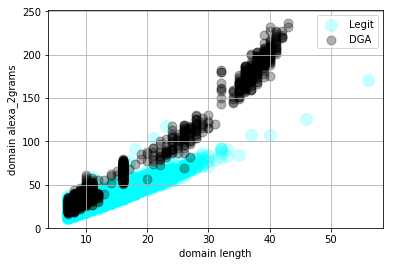

In [25]:
condition = all_domains['class'] == 'dga'
plot2Dfeatures(all_domains, 'length', 'alexa_2grams', condition)

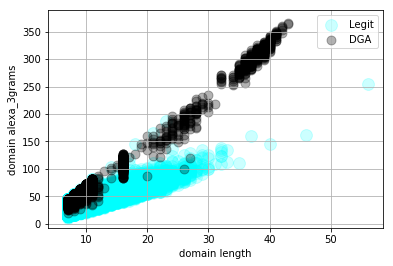

In [26]:
condition = all_domains['class'] == 'dga'
plot2Dfeatures(all_domains, 'length', 'alexa_3grams', condition)

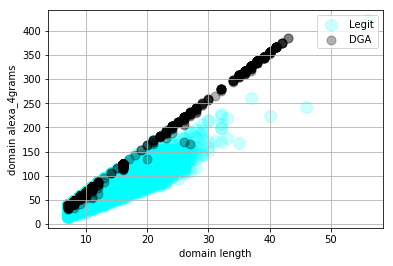

In [34]:
condition = all_domains['class'] == 'dga'
plot2Dfeatures(all_domains, 'length', 'alexa_4grams', condition)

Notice that the 

In [69]:
hold_out_domains[(hold_out_domains['class']=='dga') & (hold_out_domains['alexa_nGrams'] < 35)].head()

,domain,class,length,alexa_2grams,alexa_3grams,alexa_4grams,alexa_nGrams
9137,uohkxtp,dga,7,28.718486,45.168583,38.463489,26.682979
9138,uoiklxlh,dga,8,33.209301,48.915546,48.081226,29.529009
9139,uolsugtlg,dga,9,31.863814,48.491665,57.712104,28.955810
9140,upcwkvg,dga,7,29.447183,42.235329,38.464754,25.728287
9143,upywkhyo,dga,8,28.545432,51.810634,48.079361,29.287883


In [80]:
weird_cond = (hold_out_domains['class']=='legit') & (all['alexa_nGrams'] < 20)
weird = all_domains[weird_cond]
print(weird.shape[0])
weird.head()

/home/darklord/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match

In [79]:
all_domains.loc[weird_cond, 'class'] = 'weird'
#print(all_domains['class'].value_counts())
#all_domains[all_domains['class'] == 'weird'].head()

IndexingError: (0       False
1       False
2       False
3       False
5       False
8       False
9       False
11      False
12      False
13      False
15      False
19      False
20      False
22      False
24      False
26      False
27      False
28      False
30      False
31      False
32      False
33      False
37      False
38      False
41      False
42      False
43      False
44      False
46      False
47      False
        ...  
9374    False
9375    False
9376    False
9377    False
9378    False
9379    False
9380    False
9381    False
9382    False
9383    False
9384    False
9385    False
9386    False
9387    False
9388    False
9389    False
9390    False
9391    False
9392    False
9393    False
9394    False
9395    False
9396    False
9397    False
9398    False
9399    False
9400    False
9401    False
9402    False
9403    False
Length: 6959, dtype: bool, 'class')

In [ ]:
hold_out_domains['alexa_2grams'] = hold_out_domains['domain'].apply(lambda domain: Ngram(domain, ngram_model=2, gram1_vocb=unigrams_vocb, gram2_vocb=bigrams_vocb))
hold_out_domains['alexa_3grams'] = hold_out_domains['domain'].apply(lambda domain: Ngram(domain, ngram_model=3, gram1_vocb=bigrams_vocb, gram2_vocb=trigrams_vocb))
hold_out_domains['alexa_4grams'] = hold_out_domains['domain'].apply(lambda domain: Ngram(domain, ngram_model=4, gram1_vocb=trigrams_vocb, gram2_vocb=quadgrams_vocb))

'''Linear Interpolation'''
lam2 = 0.3
lam3 = 0.4
lam4 = 0.3
hold_out_domains['alexa_nGrams'] = lam2 * hold_out_domains['alexa_2grams'] + lam3 * hold_out_domains['alexa_3grams'] + lam4 * hold_out_domains['alexa_4grams']

hold_out_domains.head()